# Chuẩn bị dữ liệu 

In [18]:
import codecs
def _generate_examples(filepath):
    examples = []
    with codecs.open(filepath, "rb") as f:
        for id_, row in enumerate(f):
            # One non-ASCII byte: sisterBADBYTEcity. We replace it with a space
            label, _, text = row.replace(b"\xf0",
                                         b" ").strip().decode().partition(" ")
            coarse_label, _, fine_label = label.partition(":")
            examples.append((id_, {
                "label-coarse": coarse_label,
                "label-fine": fine_label,
                "text": text,
            }))
    return examples 

In [19]:
train = _generate_examples("train_5500.label")
test = _generate_examples("TREC_10.label")

In [20]:
# lấy danh sách các nhãn trong dữ liệu huấn luyện
labels = [x['label-coarse'] for _, x in train]
set_labels = list(set(labels))
label2id = {x: i for i, x in enumerate(set_labels)}
id2label = {i: x for i, x in enumerate(set_labels)}

print("------")
print(len(labels))
print("------")
print(set_labels)
print("------")
print(label2id)
print("------")
print(id2label)

------
5452
------
['DESC', 'HUM', 'NUM', 'ENTY', 'LOC', 'ABBR']
------
{'DESC': 0, 'HUM': 1, 'NUM': 2, 'ENTY': 3, 'LOC': 4, 'ABBR': 5}
------
{0: 'DESC', 1: 'HUM', 2: 'NUM', 3: 'ENTY', 4: 'LOC', 5: 'ABBR'}


In [21]:
train_target = [label2id[x['label-coarse']] for _, x in train]
train_data = [x['text'] for _, x in train]

test_data = [x['text'] for _, x in test]
test_target = [label2id[x['label-coarse']] for _, x in test]


print("#training size", len(train))
print("#testing size", len(test))
print(train[0])
print(train[1])
print(test[0])
print(test[1])
print(train_data[0], train_target[0])
print(train_data[1], train_target[1])

#training size 5452
#testing size 500
(0, {'label-coarse': 'DESC', 'label-fine': 'manner', 'text': 'How did serfdom develop in and then leave Russia ?'})
(1, {'label-coarse': 'ENTY', 'label-fine': 'cremat', 'text': 'What films featured the character Popeye Doyle ?'})
(0, {'label-coarse': 'NUM', 'label-fine': 'dist', 'text': 'How far is it from Denver to Aspen ?'})
(1, {'label-coarse': 'LOC', 'label-fine': 'city', 'text': 'What county is Modesto , California in ?'})
How did serfdom develop in and then leave Russia ? 0
What films featured the character Popeye Doyle ? 3


# Pipeline 

In [32]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

C =  3.0
use_idf = True
ngram_range=(1, 2)
    
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=ngram_range)),
    ('tfidf', TfidfTransformer(use_idf=use_idf)),
    ('clf', svm.LinearSVC(C=C)),
])

In [33]:
text_clf.fit(train_data, train_target)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=3.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                     

In [34]:
text_clf.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 2), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   LinearSVC(C=3.0, class_weight=None, dual=True, fit_intercept=True,
             intercept_scaling=1, loss='squared_hinge', max_iter=1000,
             multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
             verbose=0))],
 'verbose': False,
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content'

# Predict 

In [35]:
docs_new = ['what is computer', 
            'who is Newton', 
            'when is the Tet holiday ?']

predicted = text_clf.predict(docs_new)
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, id2label[category]))

'what is computer' => DESC
'who is Newton' => HUM
'when is the Tet holiday ?' => NUM


In [36]:
predicted = text_clf.predict(test_data)
ncorrect = sum([y_pred == y for y_pred, y in zip (predicted, test_target)])
accurracy = ncorrect / len(test_target)
accurracy

0.892

In [37]:
y_pred = text_clf['clf'].predict(text_clf['tfidf'].transform(text_clf['vect'].transform(test_data)))
ncorrect = sum([y_pred == y for y_pred, y in zip (predicted, test_target)])
accurracy = ncorrect / len(test_target)
accurracy

0.892

# GridSearch

In [28]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': (1.0, 2.0, 3.0)
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(train_data, train_target)

In [29]:
gs_clf.best_score_

0.8637176565561434

In [30]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__C: 3.0
tfidf__use_idf: True
vect__ngram_range: (1, 2)


In [31]:
gs_clf.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=3.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                     

Optimal number of features : 23


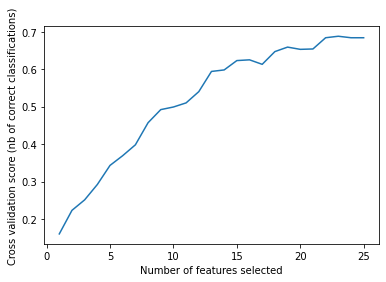

In [15]:

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=20,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()